In [1]:
from manifold_learning import IMD
from FastCCM import CCM
import numpy as np
from pydmd import DMD, BOPDMD
from manifold_learning.utils import utils
from sklearn.decomposition import PCA
from pydmd.preprocessing import zero_mean_preprocessing
from pydmd.plotter import plot_summary
from manifold_learning.data.data_loader import load_csv_dataset,get_truncated_lorenz_rand
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import imageio
import os
import tempfile
import importlib
importlib.reload(IMD)
importlib.reload(CCM)
importlib.reload(utils)

<module 'manifold_learning.utils.utils' from '/home/iaroslav/Documents/Python projects/manifold_learning/src/manifold_learning/utils/utils.py'>

In [41]:
X = get_truncated_lorenz_rand(400,n_steps=20000)

In [3]:
def gaussian_kernel(x, y, sigma=1.0):
    return np.exp(-np.linalg.norm(x - y,axis=1)**2 / (2 * sigma**2))

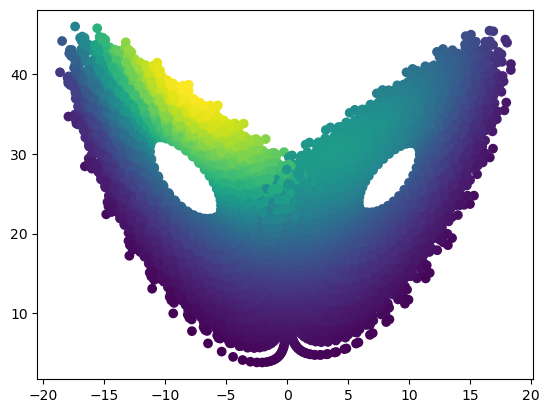

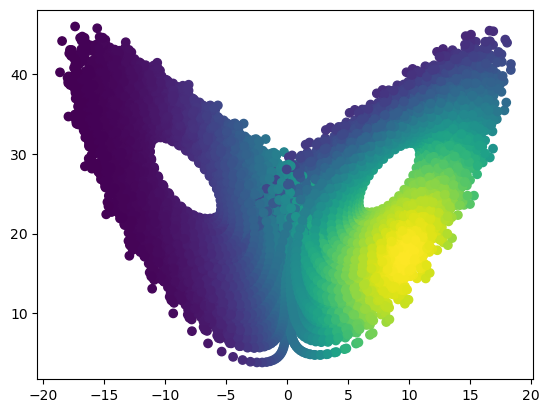

In [4]:
plt.scatter(X[:,0],X[:,2],c=gaussian_kernel(X,X[1100],sigma=15))
plt.show()
plt.scatter(X[:,0],X[:,2],c=gaussian_kernel(X,X[1800],sigma=15))
plt.show()

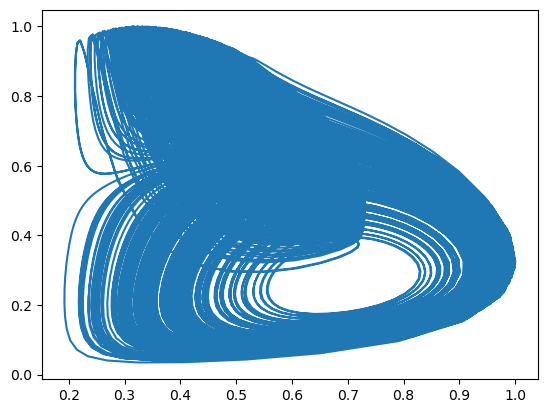

In [5]:
plt.plot(gaussian_kernel(X,X[1100],sigma=20),gaussian_kernel(X,X[1800],sigma=20))

In [35]:
exp_kernel_grid = np.array(np.meshgrid(np.linspace(X[:,0].min(),X[:,0].max(),6), np.linspace(X[:,2].min(),X[:,2].max(),6))).reshape(2,-1).T

In [36]:
observables = np.array([gaussian_kernel(X[:,[0,2]],e,sigma=5) for e in exp_kernel_grid]).T

In [34]:
exp_kernel_grid = np.array(np.meshgrid(np.linspace(X[:,0].min(),X[:,0].max(),40), np.linspace(X[:,2].min(),X[:,2].max(),40))).reshape(2,-1).T
observables = np.array([gaussian_kernel(X[:,[0,2]],e,sigma=5) for e in exp_kernel_grid]).T
with tempfile.TemporaryDirectory() as tempdir:
    filenames = []
    for i, frame in enumerate(observables.reshape(-1,40,40)[:2000]):
        plt.imshow(frame, cmap='viridis')
        plt.axis('off')
        filename = os.path.join(tempdir, f'frame_{i}.png')
        plt.savefig(filename)
        filenames.append(filename)
        plt.close()

    with imageio.get_writer('output.mp4', fps=30) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

/tmp/ipykernel_474863/4228224139.py:13: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



In [37]:
X_ = [get_truncated_lorenz_rand(400,n_steps=20000)[:,[0,2]] for i in range(5)]
observables = np.concatenate([np.array([gaussian_kernel(x,e,sigma=15) for e in exp_kernel_grid]) for x in X_]).T


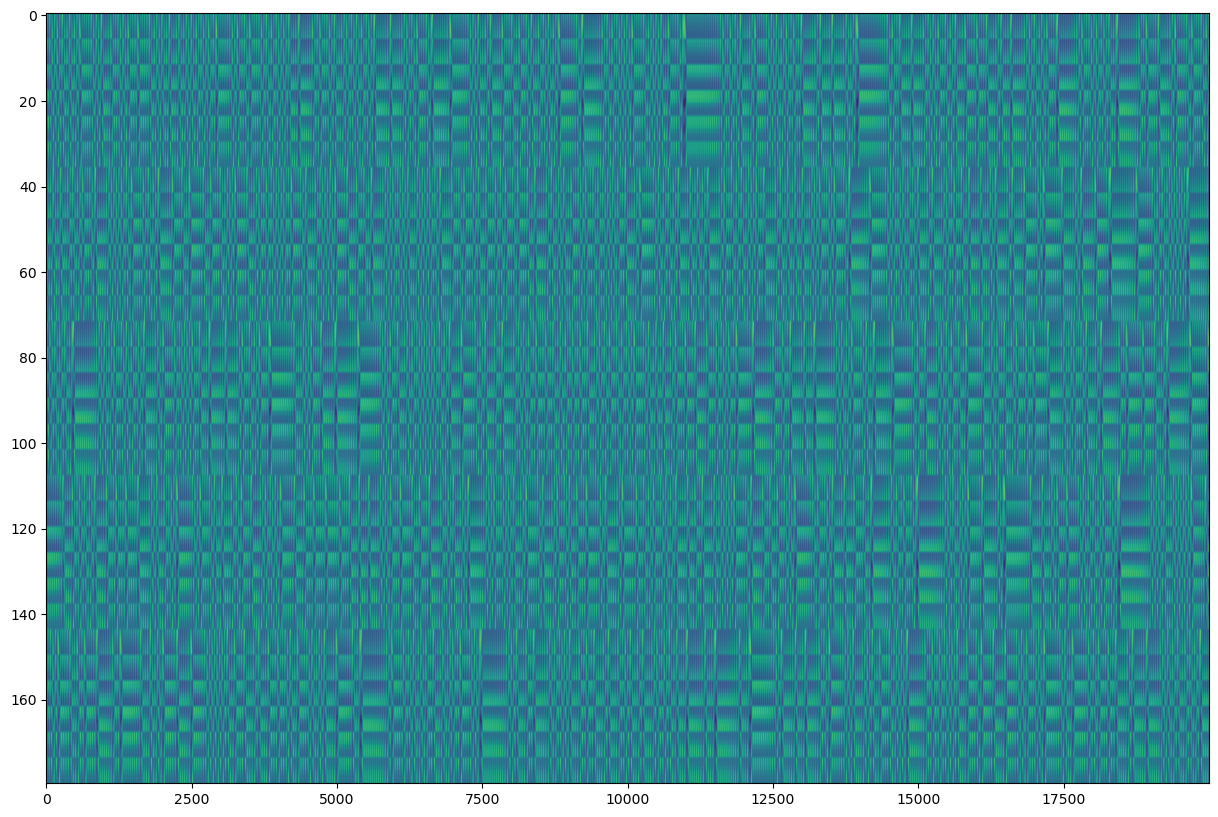

In [11]:
plt.figure(figsize=(15,10))
plt.imshow(observables.T,aspect="auto")

In [302]:
observables = utils.get_td_embedding_np(observables,3,5).reshape(-1,3*observables.shape[1])


In [10]:
observables = StandardScaler().fit_transform(observables)

In [14]:
trainer = IMD.IMD_nD(observables.shape[1], embed_dim=15, n_components=10,subtract_corr=True, device="cuda")

In [15]:
trainer.fit(observables, sample_len=400, library_len=1200, 
            exclusion_rad=20, nbrs_num=30, tp=20, 
            epochs=300, num_batches=32,optimizer="Adagrad", learning_rate=0.002,tp_policy="fixed")


Epoch 1/300, Loss: 1.2967
Epoch 2/300, Loss: 1.2399
Epoch 3/300, Loss: 1.2098
Epoch 4/300, Loss: 1.1895
Epoch 5/300, Loss: 1.1708
Epoch 6/300, Loss: 1.1551
Epoch 7/300, Loss: 1.1410
Epoch 8/300, Loss: 1.1254
Epoch 9/300, Loss: 1.1137
Epoch 10/300, Loss: 1.0985
Epoch 11/300, Loss: 1.0859
Epoch 12/300, Loss: 1.0723
Epoch 13/300, Loss: 1.0580
Epoch 14/300, Loss: 1.0452
Epoch 15/300, Loss: 1.0310
Epoch 16/300, Loss: 1.0176
Epoch 17/300, Loss: 1.0034
Epoch 18/300, Loss: 0.9878
Epoch 19/300, Loss: 0.9737
Epoch 20/300, Loss: 0.9589
Epoch 21/300, Loss: 0.9447
Epoch 22/300, Loss: 0.9301
Epoch 23/300, Loss: 0.9178
Epoch 24/300, Loss: 0.9014
Epoch 25/300, Loss: 0.8858
Epoch 26/300, Loss: 0.8732
Epoch 27/300, Loss: 0.8556
Epoch 28/300, Loss: 0.8425
Epoch 29/300, Loss: 0.8338
Epoch 30/300, Loss: 0.8187
Epoch 31/300, Loss: 0.8077
Epoch 32/300, Loss: 0.7946
Epoch 33/300, Loss: 0.7865
Epoch 34/300, Loss: 0.7737
Epoch 35/300, Loss: 0.7663
Epoch 36/300, Loss: 0.7549
Epoch 37/300, Loss: 0.7477
Epoch 38/3

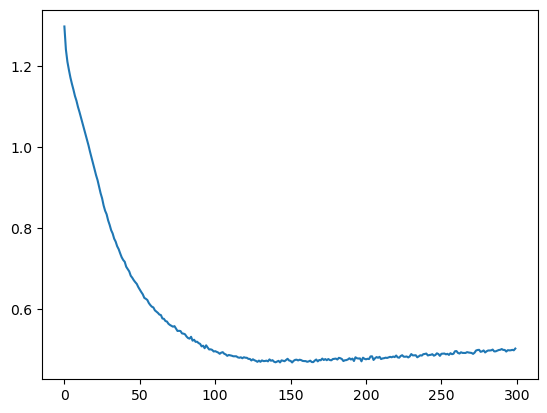

In [16]:
plt.plot(trainer.get_loss_history()[:])


In [17]:

unmixed = trainer.predict(observables)

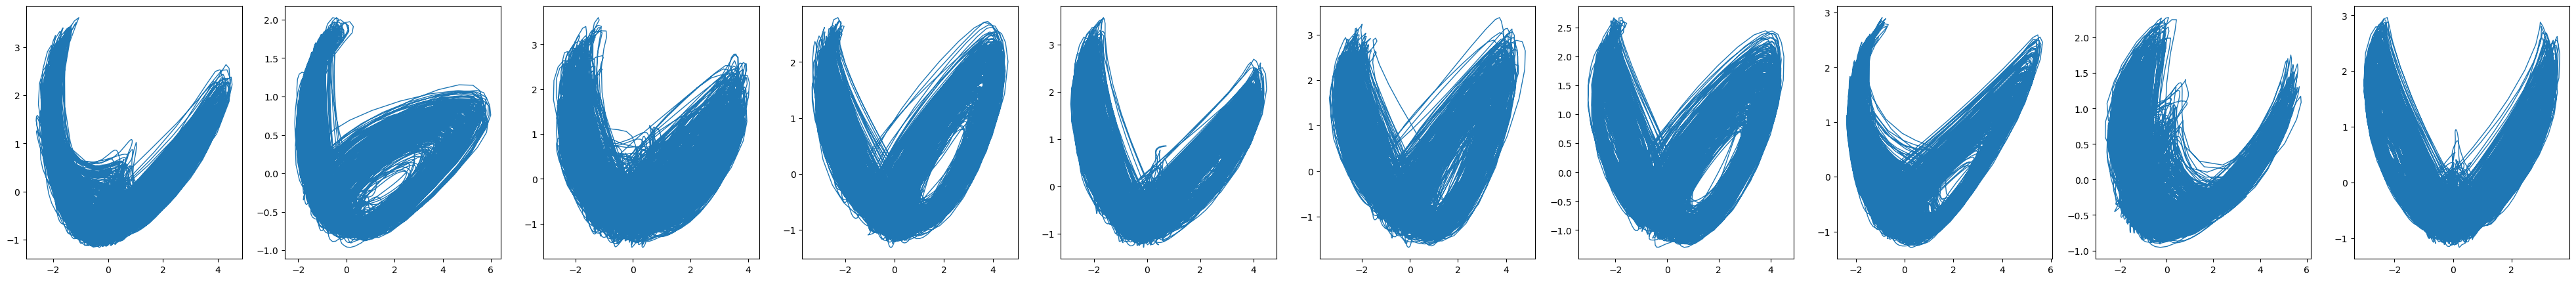

In [18]:
plt.figure(figsize=(5*unmixed.shape[1],5))
for i in range(unmixed.shape[1]):
    plt.subplot(1,unmixed.shape[1],i+1)
    x_pca = PCA(2).fit_transform(unmixed[:,i,:])
    plt.plot(x_pca[:,0],x_pca[:,1],linewidth=1)

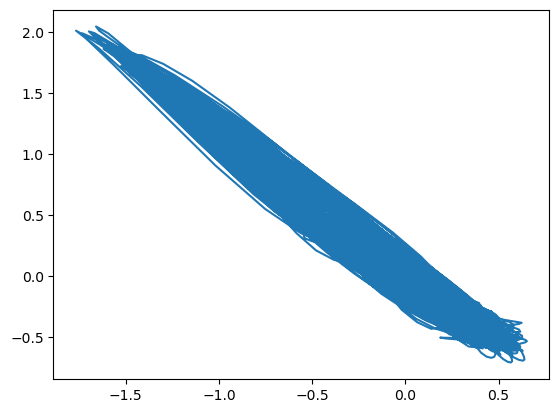

In [19]:
plt.plot(unmixed[:,4,1],unmixed[:,4,2])

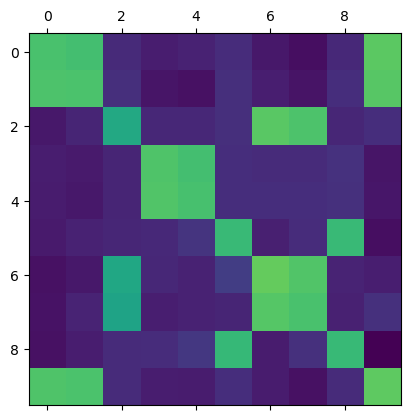

In [28]:
plt.matshow(CCM.PairwiseCCM().compute(np.transpose(unmixed,axes=(1,0,2)),np.transpose(unmixed,axes=(1,0,2)),1500,400,60,30,30).mean(axis=0),vmax=1)

In [38]:
import plotly.express as px
x_pca = PCA(3).fit_transform(unmixed[:,1,:])
fig = px.line_3d(x=x_pca[:,0], y=x_pca[:,1],z=x_pca[:,2],height=700)

fig.show()

In [22]:
bopdmd = BOPDMD(svd_rank=30, num_trials=0)

bopdmd.fit(observables.T,np.arange(observables.shape[0]))

/home/iaroslav/miniconda3/lib/python3.12/site-packages/pydmd/snapshots.py:73: UserWarning:

Input data condition number 98769013.74768077. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.

/home/iaroslav/miniconda3/lib/python3.12/site-packages/pydmd/bopdmd.py:751: UserWarning:

Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.



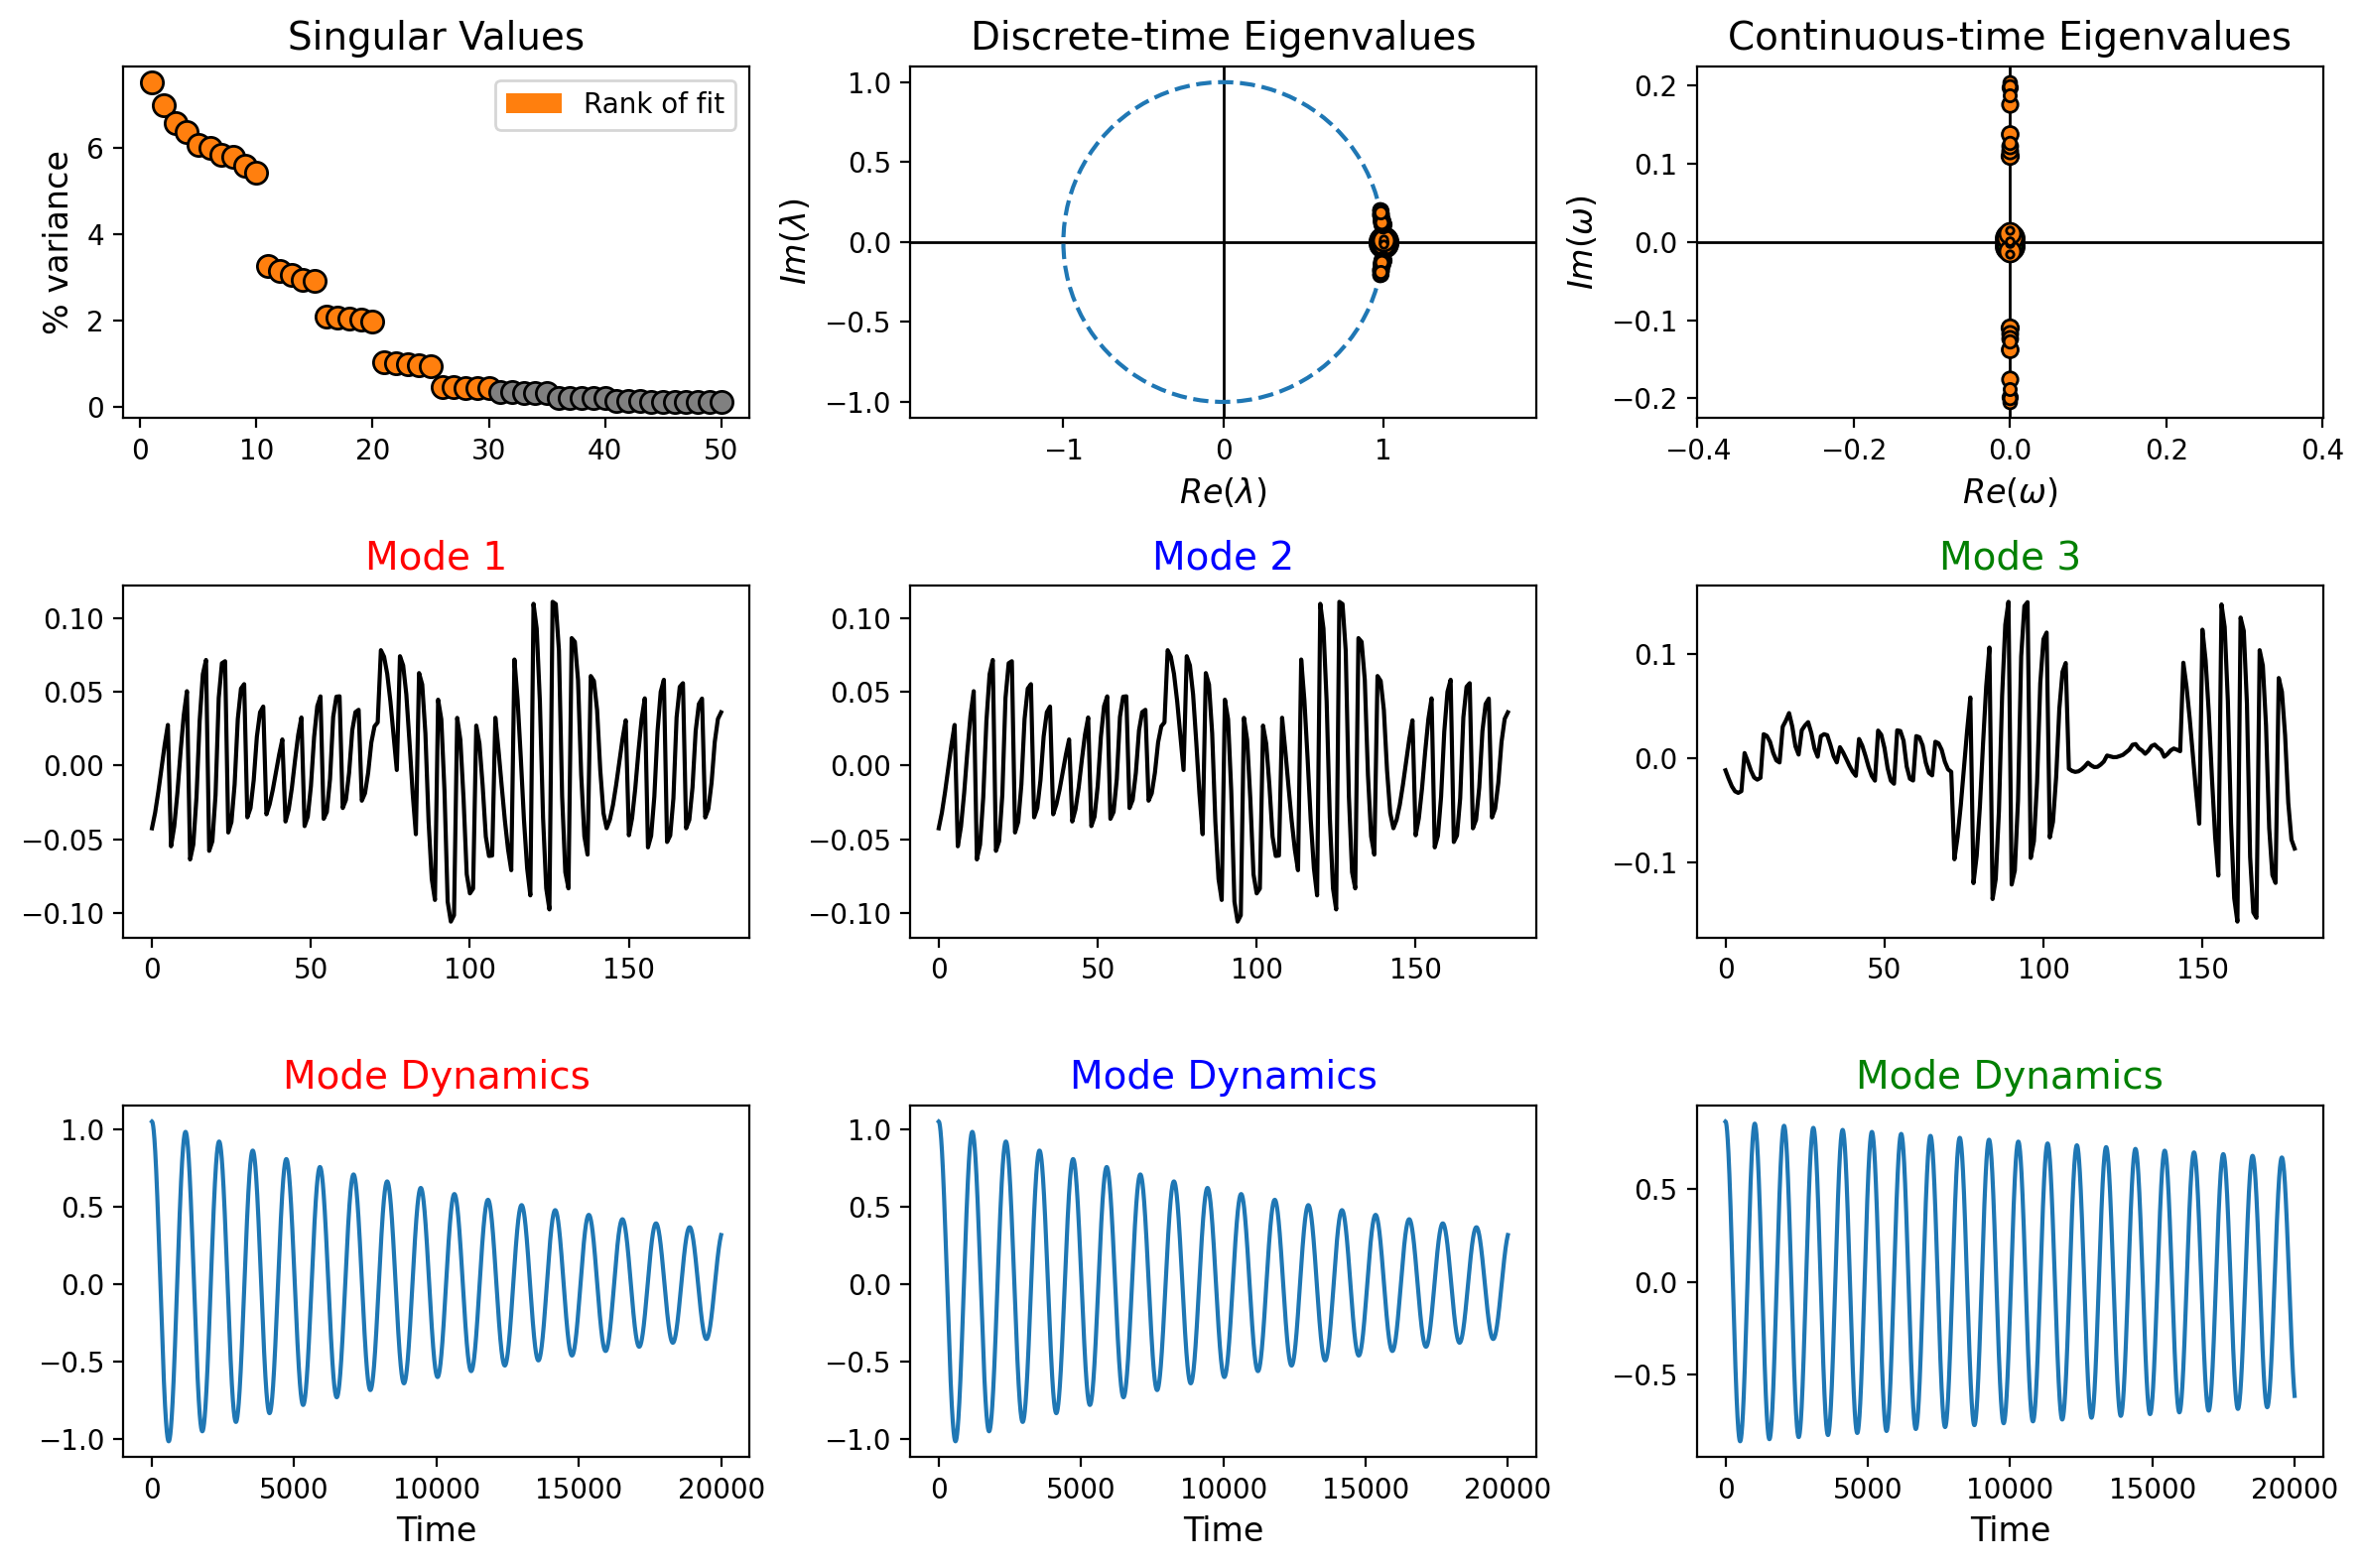

In [23]:

plot_summary(bopdmd)

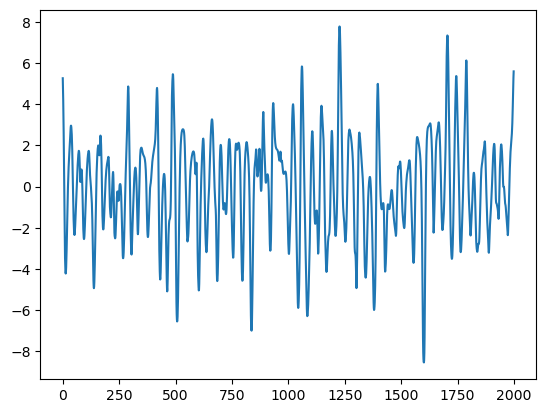

In [24]:
plt.plot((observables @ bopdmd.modes[:,2].real)[:2000])

/home/iaroslav/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning:

Casting complex values to real discards the imaginary part

/home/iaroslav/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning:

Casting complex values to real discards the imaginary part



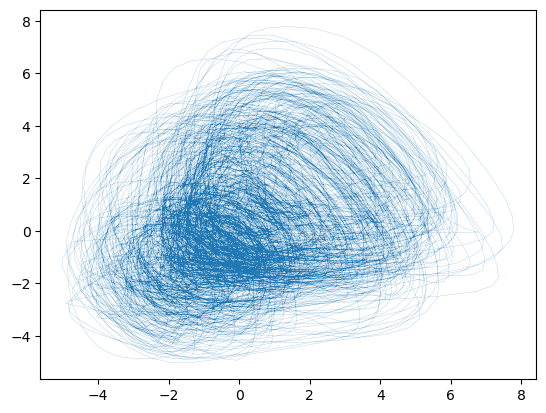

In [25]:
plt.plot((observables @ bopdmd.modes)[10:,1],(observables @ bopdmd.modes)[:-10,1],linewidth=0.1)